In [10]:
# %pip install statsmodels
# %pip install patsy


In [11]:
import pandas as pd 
import math
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv('data/2019 Line 187 allscripts.csv')
df.head()
df['Actual Depart Hour'] = df['Actual Depart'].str.split(':',expand=True)[0]
df['Actual Depart Hour'] = df['Actual Depart Hour'].astype(int)
df['Transit Date Month'] = df['Transit Date'].str.split('/',expand=True)[0]
df['Transit Date Month'] = df['Transit Date Month'].astype(int)

/var/folders/sl/46hc8zqn0l9_kwvskdqj7z8h0000gn/T/ipykernel_5864/1621572889.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1.drop(['Transit Date', 'Badge #', 'Block #', 'Stop Sequence', 'Latitude', 'Longitude', 'Actual Arrival', 'Dwell Time', \
/var/folders/sl/46hc8zqn0l9_kwvskdqj7z8h0000gn/T/ipykernel_5864/1621572889.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train


CPU times: user 947 ms, sys: 29.6 ms, total: 976 ms
Wall time: 977 ms


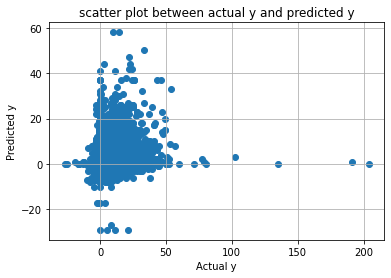

Root Mean Squared Error : 6.573854567792417
Mean Absolute Error : 3.465932735595657


/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[0.31530168 0.3258937  0.31738226 0.3210367  0.3183882 ]
0.32 accuracy with a standard deviation of 0.00


In [12]:
df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
#df1 = df.loc[(df['Bus Stop ID'] != 177)]
#df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
#df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
#df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
df1.head()
# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Badge #', 'Block #', 'Stop Sequence', 'Latitude', 'Longitude', 'Actual Arrival', 'Dwell Time', \
    'Scheduled Run Time', 'Actual Run Time', 'Actual Depart', 'Prev Departure Offset'], 1, inplace=True)
# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# lr_sgd = SGDRegressor(loss='huber', penalty='l1')
# lr_sgd = SGDRegressor(penalty='elasticnet')
lr_sgd = DecisionTreeClassifier()

%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Root Mean Squared Error :',math.sqrt(mean_squared_error(Y_test, lr_sgd.predict(X_test))))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()